In [1]:
import numpy as np
import scipy as sp
from petsc4py import PETSc
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xhermes
import xbout
import sys
sys.path.append("/home/mike/work/sdtools")
from hermes3.case_db import *

%load_ext autoreload
%autoreload 2

Failed to import dill, some functionality will not be available.


# Read DMPlex

In [ ]:
dmplex_path = r"/home/mike/work/hermes3v/builds/newbuild/tests/integrated/dmplex/dmplex_mastu.h5"

dm = PETSc.DMPlex().create()
viewer = PETSc.Viewer().createHDF5(dmplex_path, 'r')
dm.load(viewer)
viewer.destroy()
dm.setFromOptions()
dm.setUp()

# Get coordinates
section = dm.getCoordinateSection()
coords = dm.getCoordinatesLocal().array
dim = dm.getCoordinateDim()

# Get all edges (cone of each edge cell)
edges = []
for p in range(dm.getChart()[0], dm.getChart()[1]):
    #if dm.getLabelValue("celltype", p) == PETSc.DMPlex.CellType.EDGE:
    cone = dm.getCone(p)
    if len(cone) == 2:
        v0, v1 = cone
        x0 = coords[section.getOffset(v0):section.getOffset(v0)+dim]
        x1 = coords[section.getOffset(v1):section.getOffset(v1)+dim]
        edges.append((x0, x1))

(-2.1, 0.1)

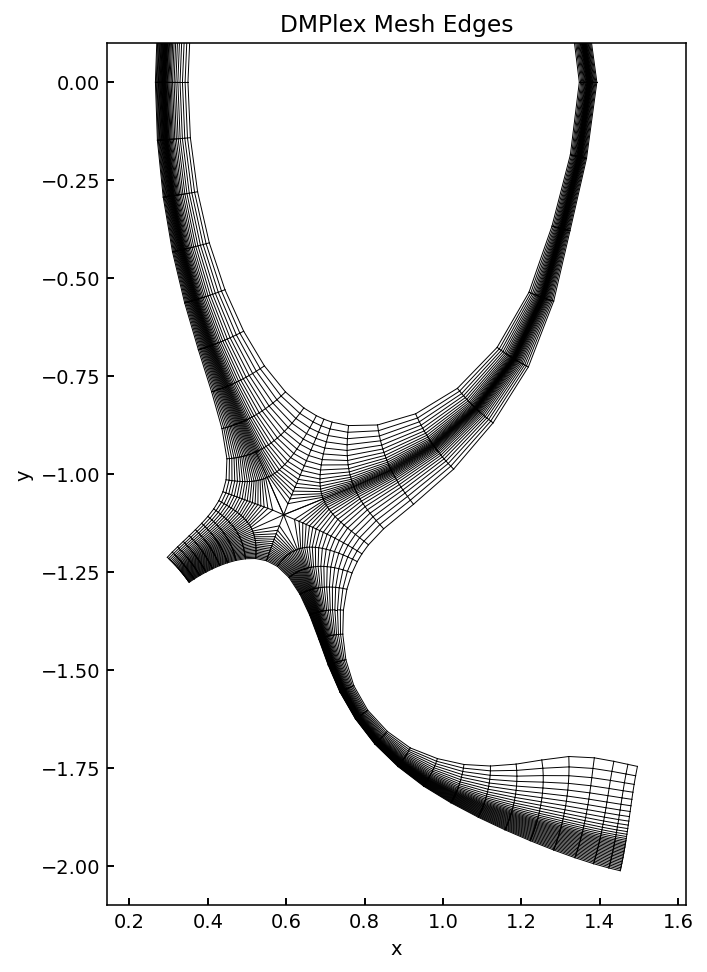

In [3]:
# Plot using object-oriented matplotlib
fig, ax = plt.subplots(figsize = (8,8))
for x0, x1 in edges:
    ax.plot([x0[0], x1[0]], [x0[1], x1[1]], color='k', linewidth=0.5)

ax.set_aspect('equal')
ax.set_title('DMPlex Mesh Edges')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim(-2.1, 0.1)

# Read Hypnotoad

In [119]:
hypno = xhermes.HypnotoadGrid(r"/home/mike/work/hermes3v/builds/newbuild/tests/integrated/dmplex/mu1af6-tunepuff.nc")
hypno_ng = hypno.remove_guards()


In [ ]:
%matplotlib widget

# Remove guards

# Plot both

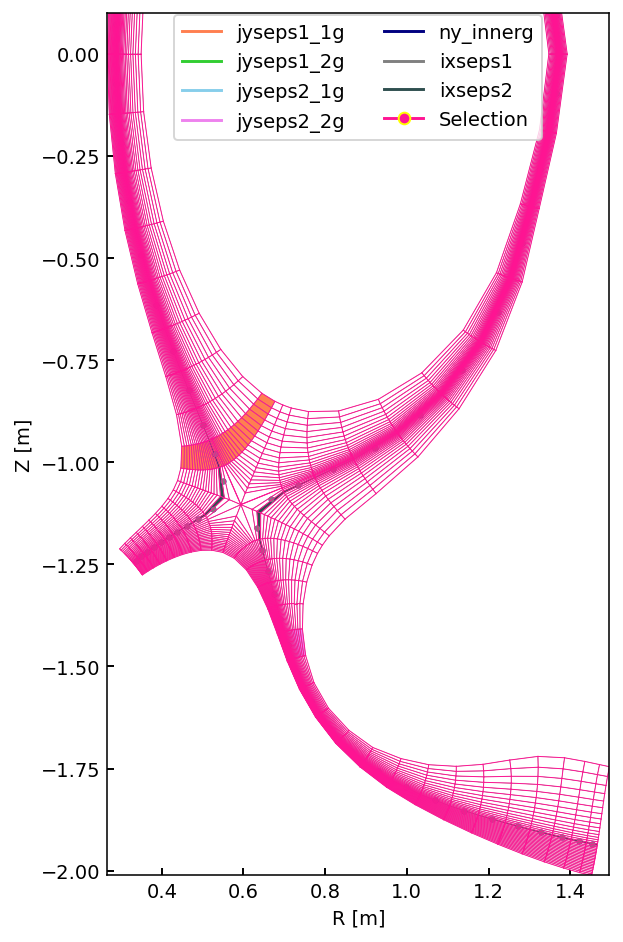

In [116]:
fig, ax = plt.subplots(figsize = (8,8))

xhermes.plotting.plot_rz_grid(hypno_ng, ax=ax, mode = "poloidal", ylim = (None, 0.1))

for x0, x1 in edges:
    ax.plot([x0[0], x1[0]], [x0[1], x1[1]], color='deeppink', linewidth=0.5)

In [36]:
[print(x) for x in hypno.keys() if "seps" in x]

ixseps1
ixseps2
jyseps1_1
jyseps2_1
jyseps1_2
jyseps2_2


[None, None, None, None, None, None]

In [40]:
hypno["y_boundary_guards"].data

array(2, dtype=int32)